In [0]:
import os
import seaborn as sn
import pandas as pd
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Activation, Dropout, GlobalAveragePooling2D, \
BatchNormalization, concatenate, AveragePooling2D
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense,Reshape
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import tensorflow as tf
from pathlib import Path
import cv2
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
tf.set_random_seed(1234)
from sklearn.metrics import f1_score

In [0]:
from google.colab import drive

drive.mount('/content/gdrive')
#os.listdir('../input')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


32*32    : rotation=180:  

In [0]:
train_gen=ImageDataGenerator(rotation_range=180,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                              rescale = 1./255, 
                             #rescale = 0.8, 
                             shear_range = 0.2,
                             zoom_range = 0.5,
                             horizontal_flip = True,
                             #featurewise_std_normalization=True,
                             fill_mode="nearest")

train = train_gen.flow_from_directory("/content/gdrive/My Drive/breast_cancer/fold1/train_mix_Norm/",
                                            class_mode="categorical",
                                            target_size=(32,32),
                                            color_mode="rgb",
                                            shuffle=True,
                                            batch_size=32)

Found 8222 images belonging to 2 classes.


In [0]:
valid_gen=ImageDataGenerator(rotation_range=180,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             rescale = 1./255,
                             #rescale = 0.8, 
                             shear_range = 0.2,
                             zoom_range = 0.5,
                             horizontal_flip = True,
                             #featurewise_std_normalization=True,
                             fill_mode="nearest")

valid = valid_gen.flow_from_directory("/content/gdrive/My Drive/breast_cancer/fold1/valid_mix_norm/",
                                            class_mode="categorical",
                                            target_size=(32, 32),
                                            color_mode="rgb",
                                            shuffle=True,
                                            batch_size=32)

Found 750 images belonging to 2 classes.


In [0]:
def conv_layer(conv_x, filters):
    conv_x = BatchNormalization()(conv_x)
    conv_x = Activation('relu')(conv_x)
    conv_x = Conv2D(filters, (3, 3), kernel_initializer='he_uniform', padding='same', use_bias=False)(conv_x)
    conv_x = Dropout(0.2)(conv_x)
    #conv_x = Dropout(0.2)(conv_x)
    #conv_x = Dropout(0.3)(conv_x) 

    return conv_x


def dense_block(block_x, filters, growth_rate, layers_in_block):
    for i in range(layers_in_block):
        each_layer = conv_layer(block_x, growth_rate)
        block_x = concatenate([block_x, each_layer], axis=-1)
        filters += growth_rate

    return block_x, filters


def transition_block(trans_x, tran_filters):
    trans_x = BatchNormalization()(trans_x)
    trans_x = Activation('relu')(trans_x)
    trans_x = Conv2D(tran_filters, (1, 1), kernel_initializer='he_uniform', padding='same', use_bias=False)(trans_x)
    trans_x = AveragePooling2D((2, 2), strides=(2, 2))(trans_x)

    return trans_x, tran_filters


def dense_net(filters, growth_rate, classes, dense_block_size, layers_in_block):
    input_img = Input(shape=(32, 32, 3))
    x = Conv2D(24, (3, 3), kernel_initializer='he_uniform', padding='same', use_bias=False)(input_img)

    dense_x = BatchNormalization()(x)
    dense_x = Activation('relu')(x)

    dense_x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(dense_x)
    for block in range(dense_block_size - 1):
        dense_x, filters = dense_block(dense_x, filters, growth_rate, layers_in_block)
        dense_x, filters = transition_block(dense_x, filters)

    dense_x, filters = dense_block(dense_x, filters, growth_rate, layers_in_block)
    dense_x = BatchNormalization()(dense_x)
    dense_x = Activation('relu')(dense_x)
    dense_x = GlobalAveragePooling2D()(dense_x)

    output = Dense(classes, activation='softmax')(dense_x)

    return Model(input_img, output)

In [0]:
dense_block_size = 3  #changed from 3 to 2
#layers_in_block = 3
layers_in_block = 5

#growth_rate = 8  # changed from 12 to 8
growth_rate = 12
classes = 2
model = dense_net(growth_rate * 2, growth_rate, classes, dense_block_size, layers_in_block)

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 24)   648         input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 24)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 16, 16, 24)   0           activation_1[0][0]               
____________________________________________________________________________________________

In [0]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics=['accuracy'])

In [0]:
len(train)

257

In [0]:
len(valid)

24

In [0]:
history = model.fit_generator(
    train,
    epochs=5,
    steps_per_epoch=257,
    validation_data=valid,
    validation_steps=24)

Epoch 1/5
257/257 [==============================] - 2536s 10s/step - loss: 0.4600 - acc: 0.7850 - val_loss: 0.4728 - val_acc: 0.8107
Epoch 2/5
257/257 [==============================] - 2327s 9s/step - loss: 0.4096 - acc: 0.8169 - val_loss: 0.5336 - val_acc: 0.8133
Epoch 3/5
257/257 [==============================] - 2289s 9s/step - loss: 0.3810 - acc: 0.8362 - val_loss: 0.6049 - val_acc: 0.7773
Epoch 4/5
257/257 [==============================] - 2319s 9s/step - loss: 0.3701 - acc: 0.8401 - val_loss: 0.6567 - val_acc: 0.7947
Epoch 5/5
257/257 [==============================] - 2306s 9s/step - loss: 0.3597 - acc: 0.8445 - val_loss: 0.7156 - val_acc: 0.7667


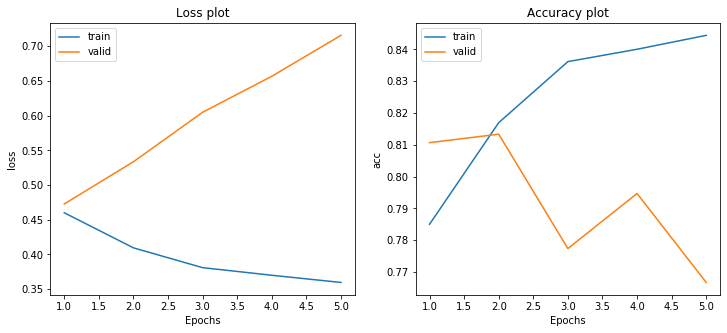

In [0]:
# plot the model loss and accuracy
train_loss = history.history['loss']
train_acc = history.history['acc']

valid_loss = history.history['val_loss']
valid_acc = history.history['val_acc']

x = [(i+1) for i in range(len(train_loss))]

f,ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(x, train_loss)
ax[0].plot(x, valid_loss)
ax[0].set_title("Loss plot")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("loss")
ax[0].legend(['train', 'valid'])


ax[1].plot(x, train_acc)
ax[1].plot(x, valid_acc)
ax[1].set_title("Accuracy plot")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("acc")
ax[1].legend(['train', 'valid'])

plt.show()

In [0]:
test_gen=ImageDataGenerator(rotation_range=180,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             rescale = 1./255,
                             #rescale = 1./255, 
                             shear_range = 0.2,
                             zoom_range = 0.5,
                             horizontal_flip = True,
                             #featurewise_std_normalization=True,
                             fill_mode="nearest")

test = test_gen.flow_from_directory("/content/gdrive/My Drive/breast_cancer/fold1/test/40X_Norm/",
                                            class_mode="categorical",
                                            target_size=(32,32),
                                            color_mode="rgb",
                                            shuffle=True,
                                            batch_size=32)

Found 160 images belonging to 2 classes.


In [0]:
loss,test_acc = model.evaluate_generator(
    test,
    steps=len(test),
    verbose=1
)

print(test_acc)

5/5 [==============================] - 55s 11s/step
0.68125


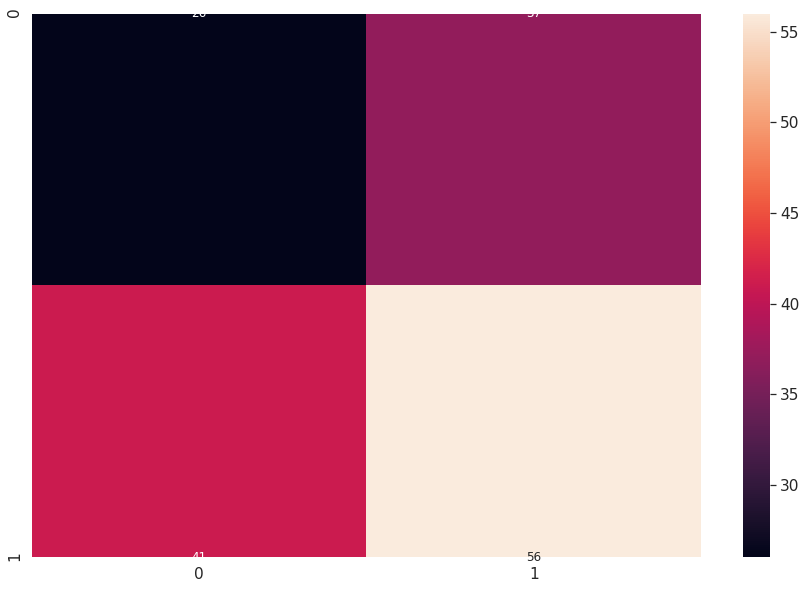

array([[26, 37],
       [41, 56]])

In [0]:
pred = model.predict_generator(test, steps=len(test))
predicted = np.argmax(pred, axis=1)

cm = confusion_matrix(test.classes, predicted)
plt.figure(figsize = (15,10))
sn.set(font_scale=1.4) #for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()
print()
cm

In [0]:
f1_score(test.classes, predicted, average='weighted')

0.5148684210526315

In [0]:
test_gen=ImageDataGenerator(rotation_range=180,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             rescale = 1./255, 
                             shear_range = 0.2,
                             zoom_range = 0.4,
                             horizontal_flip = True,
                             #featurewise_std_normalization=True,
                             fill_mode="nearest")

test = test_gen.flow_from_directory("/content/gdrive/My Drive/breast_cancer/fold1/test/100X_Norm/",
                                            class_mode="categorical",
                                            target_size=(32, 32),
                                            color_mode="rgb",
                                            shuffle=True,
                                            batch_size=32)

Found 209 images belonging to 2 classes.


In [0]:
loss,test_acc = model.evaluate_generator(
    test,
    steps=len(test),
    verbose=1
)

print(test_acc)

7/7 [==============================] - 67s 10s/step
0.851674641433515


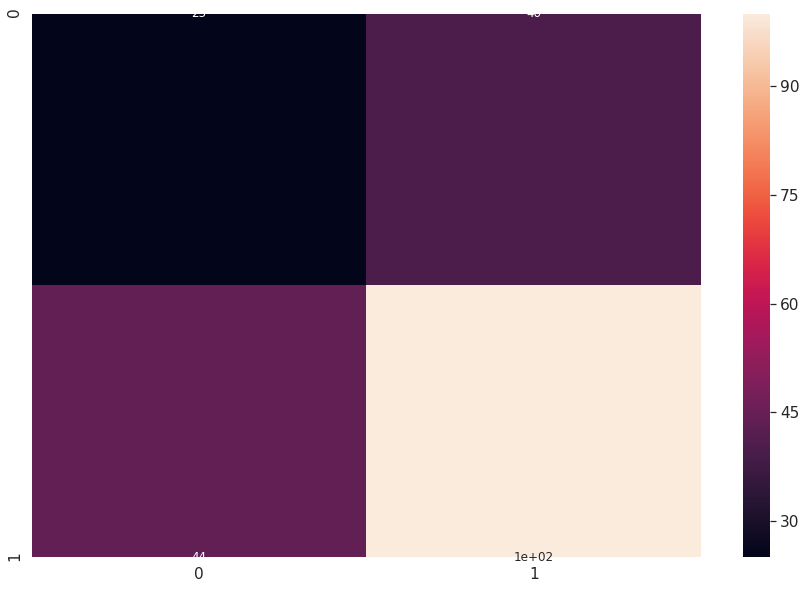

array([[ 25,  40],
       [ 44, 100]])

In [0]:
pred = model.predict_generator(test, steps=len(test))
predicted = np.argmax(pred, axis=1)

cm = confusion_matrix(test.classes, predicted)
plt.figure(figsize = (15,10))
sn.set(font_scale=1.4) #for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()
print()
cm

In [0]:
f1_score(test.classes, predicted, average='weighted')

0.601254459557459

In [0]:
test_gen=ImageDataGenerator(rotation_range=180,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             rescale = 1./255, 
                             shear_range = 0.2,
                             zoom_range = 0.4,
                             horizontal_flip = True,
                             #featurewise_std_normalization=True,
                             fill_mode="nearest")

test = test_gen.flow_from_directory("/content/gdrive/My Drive/breast_cancer/fold1/test/200X_Norm/",
                                            class_mode="categorical",
                                            target_size=(32, 32),
                                            color_mode="rgb",
                                            shuffle=True,
                                            batch_size=32)

Found 202 images belonging to 2 classes.


In [0]:
loss,test_acc = model.evaluate_generator(
    test,
    steps=len(test),
    verbose=1
)

print(test_acc)

7/7 [==============================] - 79s 11s/step
0.8465346540554916


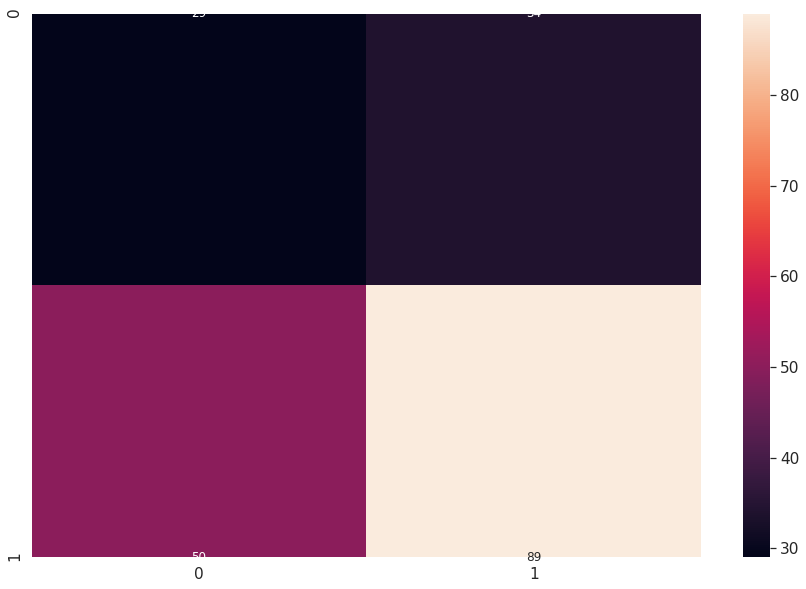

array([[29, 34],
       [50, 89]])

In [0]:
pred = model.predict_generator(test, steps=len(test))
predicted = np.argmax(pred, axis=1)

cm = confusion_matrix(test.classes, predicted)
plt.figure(figsize = (15,10))
sn.set(font_scale=1.4) #for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()
print()
cm

In [0]:
f1_score(test.classes, predicted, average='weighted')

0.5948886577723465

In [0]:
test_gen=ImageDataGenerator(rotation_range=180,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             rescale = 1./255, 
                             shear_range = 0.2,
                             zoom_range = 0.5,
                             horizontal_flip = True,
                             #featurewise_std_normalization=True,
                             fill_mode="nearest")

test = test_gen.flow_from_directory("/content/gdrive/My Drive/breast_cancer/fold1/test/400X_Norm/",
                                            class_mode="categorical",
                                            target_size=(32, 32),
                                            color_mode="rgb",
                                            shuffle=True,
                                            batch_size=32)

Found 183 images belonging to 2 classes.


In [0]:
loss,test_acc = model.evaluate_generator(
    test,
    steps=len(test),
    verbose=1
)

print(test_acc)

6/6 [==============================] - 63s 11s/step
0.7923497231931634


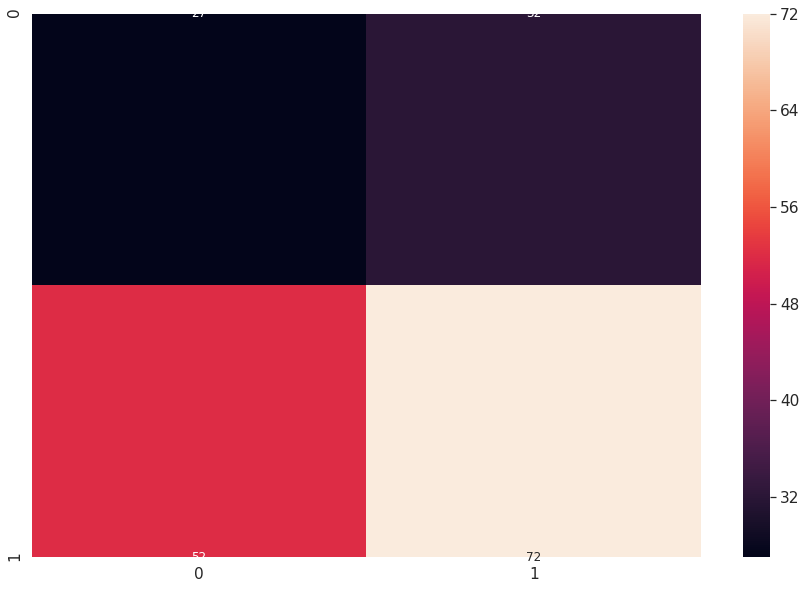

array([[27, 32],
       [52, 72]])

In [0]:
pred = model.predict_generator(test, steps=len(test))
predicted = np.argmax(pred, axis=1)

cm = confusion_matrix(test.classes, predicted)
plt.figure(figsize = (15,10))
sn.set(font_scale=1.4) #for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()
print()
cm

In [0]:
f1_score(test.classes, predicted, average='weighted')

0.5541133660952096

In [0]:
test_gen=ImageDataGenerator(rotation_range=180,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             rescale = 1./255, 
                             shear_range = 0.2,
                             zoom_range = 0.5,
                             horizontal_flip = True,
                             #featurewise_std_normalization=True,
                             fill_mode="nearest")

test = test_gen.flow_from_directory("/content/gdrive/My Drive/breast_cancer/fold1/test_mix_Norm/",
                                            class_mode="categorical",
                                            target_size=(32, 32),
                                            color_mode="rgb",
                                            shuffle=True,
                                            batch_size=32)

Found 754 images belonging to 2 classes.


In [0]:
loss,test_acc = model.evaluate_generator(
    test,
    steps=len(test),
    verbose=1
)

print(test_acc)

24/24 [==============================] - 227s 9s/step
0.7108753312487818


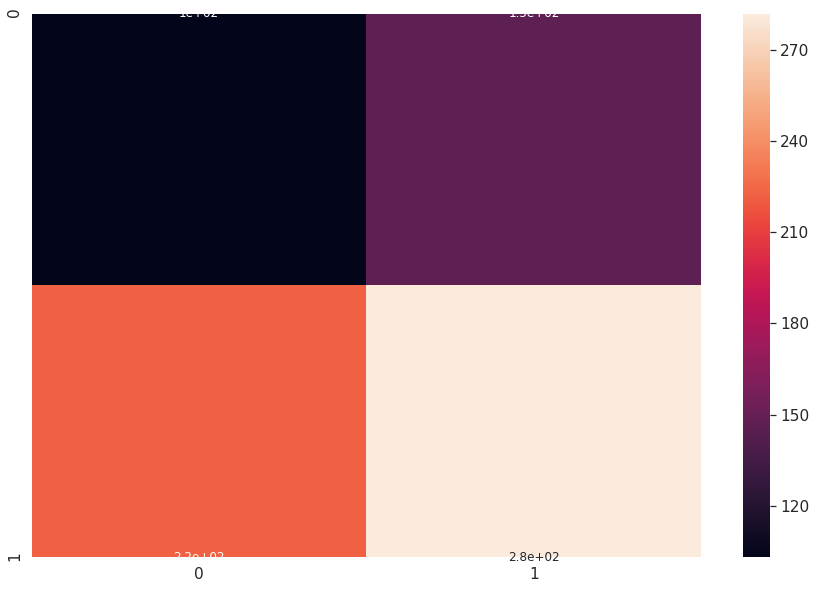

array([[103, 147],
       [222, 282]])

In [0]:
pred = model.predict_generator(test, steps=len(test))
predicted = np.argmax(pred, axis=1)

cm = confusion_matrix(test.classes, predicted)
plt.figure(figsize = (15,10))
sn.set(font_scale=1.4) #for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()
print()
cm

In [0]:
f1_score(test.classes, predicted, average='weighted')

0.5228568006375245